In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msn
import dexplot as dxp

In [2]:
import numpy as np
from scipy.stats import spearmanr

In [3]:

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb

In [4]:
train=pd.read_csv("training_set_VU_DM.csv")
#test=pd.read_csv("test_set_VU_DM.csv")


In [5]:
to_drop= ['comp1_rate',
'comp1_inv',
'comp1_rate_percent_diff',
'comp2_rate',
'comp2_inv',
'comp2_rate_percent_diff',
'comp3_rate',
'comp3_inv',
'comp3_rate_percent_diff',
'comp4_rate',
'comp4_inv',
'comp4_rate_percent_diff',
'comp5_rate',
'comp5_inv',
'comp5_rate_percent_diff',
'comp6_rate',
'comp6_inv',
'comp6_rate_percent_diff',
'comp7_rate',
'comp7_inv',
'comp7_rate_percent_diff',
'comp8_rate',
'comp8_inv',
'comp8_rate_percent_diff'

]

#train['outcome'] = pd.Series(train['booking_bool']> 0, 500 + train['position'] , train['click_bool']> 0, 100 +train['position'] , 0 + train['position'] )

conditions = [
    #(train['booking_bool']> 0),
    (train['click_bool']> 0)
]

#choices = [500+(40 - train['position']) ,100+(40 - train['position'])]
#train['outcome'] = np.select(conditions, choices, default=(40 - train['position'])

#choices = [2 ,1]
choices = [1]
train['outcome'] = np.select(conditions, choices, default=0)

train = train.drop(to_drop,  axis=1)#.sample(frac=0.2, replace=True, random_state=1)
#test_reduced  = test.iloc[: , :N].sample(frac=0.33, replace=True, random_state=1)

In [133]:
train['max_price'] = train.groupby('srch_id')['price_usd'].transform('max') 
train['min_price'] = train.groupby('srch_id')['price_usd'].transform('min') 
train['mean_price'] = train.groupby('srch_id')['price_usd'].transform('mean') 
train['diff_max_price'] =(train['max_price'] -train['price_usd']) / train['price_usd']
train['diff_min_price'] = (train['min_price'] - train['price_usd'])/ train['price_usd']
train['diff_min_price'] = train['diff_min_price'].replace(np.nan, 0)
train['diff_mean_price'] = (train['mean_price'] - train['price_usd']) / train['price_usd']


In [134]:
train['hotel_click_prob'] = train.groupby('prop_id')['click_bool'].transform('sum') / train.groupby('prop_id')['click_bool'].transform('count')
#pd.crosstab(train.hotel_click_prob, train.prop_id, dropna=False)



In [135]:
train['hotel_buy_prob'] = train.groupby('prop_id')['booking_bool'].transform('sum') / train.groupby('prop_id')['booking_bool'].transform('count')
#pd.crosstab(train.hotel_buy_prob, train.prop_id, dropna=False)


In [136]:
train['outcome'].value_counts()


0    4736468
1     221879
Name: outcome, dtype: int64

In [137]:
train_reduced = train.groupby('outcome')
train_reduced = pd.DataFrame(train_reduced.apply(lambda x: x.sample(train_reduced.size().min()).reset_index(drop=True)))

In [138]:
# conditions = [
#     (train['booking_bool']> 0),
#     (train['click_bool']> 0)
# ]

# choices = [500+train['position'],100+train['position'], train['position']]
# train['outcome'] = np.select(conditions, choices, default=train['position'])

In [139]:
train_reduced.isnull().mean() * 100

srch_id                         0.000000
date_time                       0.000000
site_id                         0.000000
visitor_location_country_id     0.000000
visitor_hist_starrating        94.933049
visitor_hist_adr_usd           94.910289
prop_country_id                 0.000000
prop_id                         0.000000
prop_starrating                 0.000000
prop_review_score               0.134533
prop_brand_bool                 0.000000
prop_location_score1            0.000000
prop_location_score2           17.277435
prop_log_historical_price       0.000000
position                        0.000000
price_usd                       0.000000
promotion_flag                  0.000000
srch_destination_id             0.000000
srch_length_of_stay             0.000000
srch_booking_window             0.000000
srch_adults_count               0.000000
srch_children_count             0.000000
srch_room_count                 0.000000
srch_saturday_night_bool        0.000000
srch_query_affin

<AxesSubplot:>

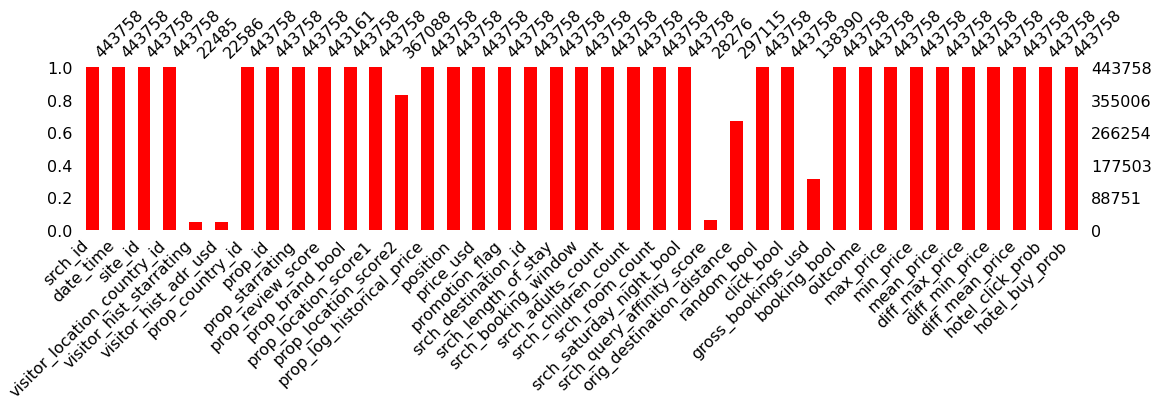

In [140]:
msn.bar(train_reduced,figsize=(18,3), color='red')

<AxesSubplot:>

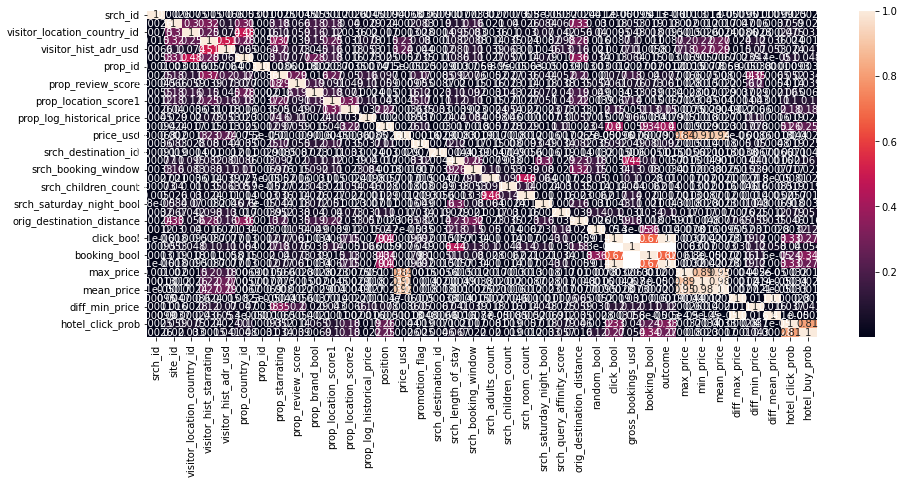

In [141]:
plt.figure(figsize=(15, 6))
sns.heatmap(train_reduced.corr().abs(),  annot=True)

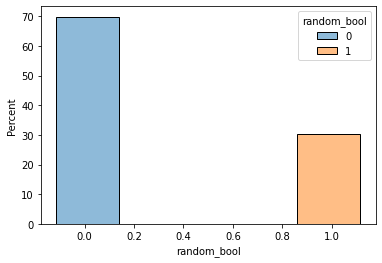

In [142]:
#ax = sns.histplot(x = train_reduced['random_bool'], hue=train_reduced['random_bool'], multiple="dodge", 
#train_reduced = train_reduced.reset_index()
ax = sns.histplot(x = train_reduced['random_bool'], hue=train_reduced['random_bool'] ,
                  stat = 'percent', shrink =10, common_norm=True)

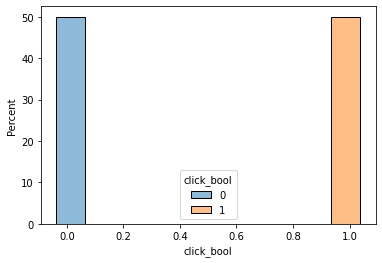

In [143]:
#ax = sns.histplot(x = train_reduced['random_bool'], hue=train_reduced['random_bool'], multiple="dodge", 
#train_reduced = train_reduced.reset_index()
ax = sns.histplot(x = train_reduced['click_bool'], hue=train_reduced['click_bool'] ,
                  stat = 'percent', shrink =4,common_norm=True)

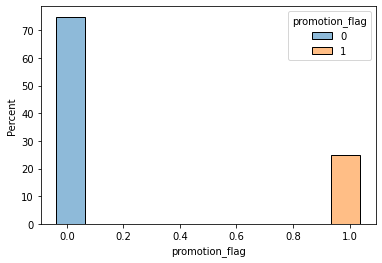

In [144]:
#ax = sns.histplot(x = train_reduced['random_bool'], hue=train_reduced['random_bool'], multiple="dodge", 
#train_reduced = train_reduced.reset_index()
ax = sns.histplot(x = train_reduced['promotion_flag'], hue=train_reduced['promotion_flag'] ,
                  stat = 'percent', shrink =4,common_norm=True)

In [145]:
# train_reduced['bought_flag'] = np.where(train_reduced['gross_bookings_usd']> 0, 1, 0)

# ax = sns.histplot(x = train_reduced['bought_flag'], hue=train_reduced['bought_flag'] ,
#                   stat = 'percent', shrink =4,common_norm=True)


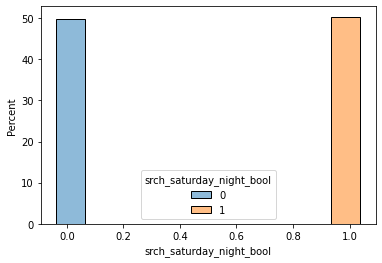

In [146]:


ax = sns.histplot(x = train_reduced['srch_saturday_night_bool'], hue=train_reduced['srch_saturday_night_bool'] ,
                  stat = 'percent', shrink =4,common_norm=True)


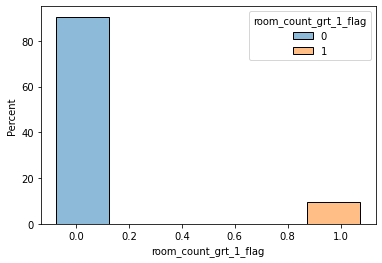

In [147]:
train_reduced['room_count_grt_1_flag'] = np.where(train_reduced['srch_room_count']> 1, 1, 0)

ax = sns.histplot(x = train_reduced['room_count_grt_1_flag'], hue=train_reduced['room_count_grt_1_flag'] ,
                  stat = 'percent', shrink =4,common_norm=True)

In [148]:
# df = train_reduced.loc[(train_reduced['gross_bookings_usd'] >= 0) & (train_reduced['gross_bookings_usd'] <= 1000)]
# sns.kdeplot(df['gross_bookings_usd'])
# plt.show()

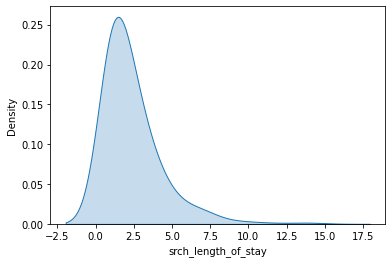

In [149]:
df = train_reduced.loc[(train_reduced['srch_length_of_stay'] >= 0) & (train_reduced['srch_length_of_stay'] <= 15)]
sns.kdeplot(df['srch_length_of_stay'], shade=True, bw_adjust=7)
plt.show()

In [159]:
train_reduced = train_reduced.loc[(train_reduced['random_bool'] == 0)]

In [160]:
to_drop = ['srch_id','site_id', 'date_time', 'visitor_location_country_id', 'prop_country_id', 'prop_id', 'prop_brand_bool', 'orig_destination_distance', 'click_bool', 'room_count_grt_1_flag', 'random_bool', 'booking_bool', 'srch_destination_id', 'position', 'prop_location_score2'
          ,'gross_bookings_usd', 'price_usd', 'max_price','min_price', 'mean_price'] 

train1 = train_reduced.drop(to_drop,  axis=1)

<AxesSubplot:>

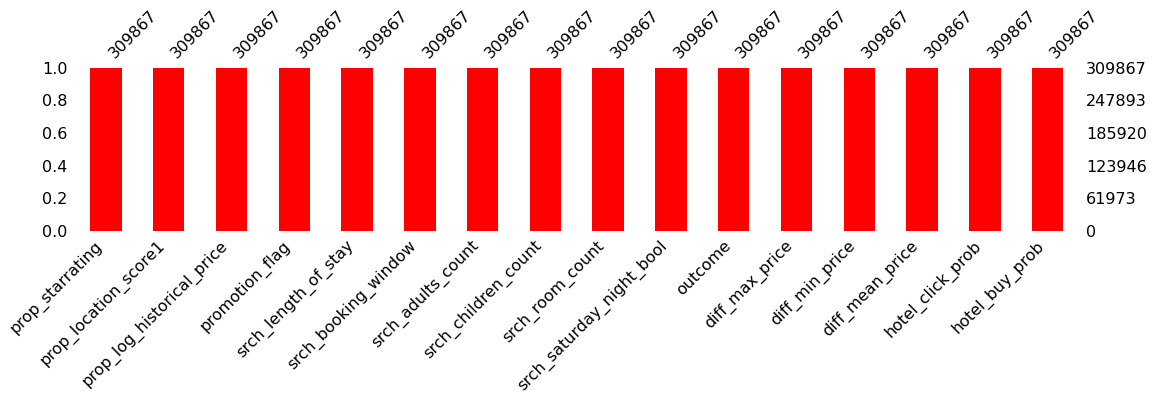

In [161]:
train1.replace([np.inf, -np.inf], 0, inplace=True)

train1=train1.dropna(axis=1,how="any")
msn.bar(train1,figsize=(18,3), color='red')

In [162]:
train1 = train1[['prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool', 'hotel_click_prob', 'hotel_buy_prob','diff_max_price','diff_min_price','diff_mean_price','outcome']]

In [163]:
#train1.reset_index()
X = train1.iloc[:, :-1].values
y = train1.iloc[:, -1].values

In [164]:
train1.head(20)



prop_starrating  prop_location_score1  prop_log_historical_price  \
outcome                                                                        
0       0                 3                  3.87                       4.64   
        2                 3                  2.71                       4.82   
        5                 4                  5.55                       5.43   
        6                 3                  1.61                       0.00   
        7                 5                  4.06                       6.21   
        8                 4                  2.48                       4.97   
        9                 2                  4.62                       5.22   
        10                4                  4.41                       5.28   
        11                3                  2.08                       4.31   
        12                3                  2.64                       0.00   
        13                4                  3.91                       5.40   
        16                2                  0.69                       4.87   
        17                3                  1.79                       4.50   
        18                5                  3.18                       6.21   
        19                4                  3.04                       5.26   
        20                2                  2.56                       4.11   
        21                4                  3.78                       5.67   
        22                4                  1.61                       5.57   
        23                3                  1.95                       5.25   
        24                4                  1.61                       6.18   

            promotion_flag  srch_length_of_stay  srch_booking_window  \
outcome                                                                
0       0                0                    1                    8   
        2                0                    2                   69   
        5                0                    8                  148   
        6                0                    1                   14   
        7                0                    1                   11   
        8                0                    1                   36   
        9                0                    2                   21   
        10               1                    1                    9   
        11               0                    1                    3   
        12               0                    1                   62   
        13               0                    2                   11   
        16               0                    1                   13   
        17               1                    7                    1   
        18               0                   11                   23   
        19               0                    7                   33   
        20               0                    1                   78   
        21               0                    1                   18   
        22               1                    1                    6   
        23               0                    1                   10   
        24               1                    1                    0   

            srch_adults_count  srch_children_count  srch_room_count  \
outcome                                                               
0       0                   2                    0                1   
        2                   2                    0                1   
        5                   2                    0                1   
        6                   2                    0                1   
        7                   2                    0                1   
        8                   4                    0                2   
        9                   1                    0                1   
        10                 

In [165]:
models_list=[
    LogisticRegression(),
  #  Lasso(),
   # RandomForestClassifier(criterion='entropy', min_samples_leaf=60,
             #          min_samples_split=4, random_state=16),
    #GradientBoostingClassifier(),
    lgb.LGBMClassifier(),
   # LinearSVC(random_state=42, C=0.01),
    #xgb.XGBRegressor(objective="reg:linear", random_state=42)   
  #  xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.1), 
 #   xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.05), #better. 
  #  xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.01), 
    #  "multi:softprob"
]

In [166]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [167]:
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
import warnings
warnings.filterwarnings('ignore')

l=[]
for model in models_list:
    #clf=clf_models(model)
    print(model)
    fit_model=model.fit(X_train, y_train)
    score=model.score(X_test, y_test)
    print("model score: %.3f" % score)
    l.append([model,'clf', score, X_test, y_test])
    #print(clf)
    #scores = -1 * cross_val_score(clf, X, y,cv=5,scoring='neg_mean_absolute_error')
    #print("MAE scores:\n", scores.mean(), scores.sum(), scores.min())
    
#print(l[3][4])
#print(l[2][3])
#print(l[2][0])

LogisticRegression()
model score: 0.664
LGBMClassifier()
model score: 0.713


In [168]:
y_pred=l[1][0].predict(X_test)

print(y_pred)

y_pred[:5]

[0 1 1 ... 1 1 1]


array([0, 1, 1, 1, 1])

In [172]:
predictors = ['prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool', 'hotel_click_prob', 'hotel_buy_prob', 'diff_max_price','diff_min_price','diff_mean_price']

In [173]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), l[1][0].feature_importances_), predictors), reverse=True))

Features sorted by their score:
[(432, 'diff_mean_price'), (387, 'hotel_click_prob'), (342, 'diff_min_price'), (333, 'diff_max_price'), (320, 'prop_log_historical_price'), (276, 'hotel_buy_prob'), (252, 'prop_location_score1'), (198, 'srch_booking_window'), (109, 'prop_starrating'), (89, 'srch_length_of_stay'), (81, 'srch_adults_count'), (55, 'srch_children_count'), (53, 'srch_room_count'), (51, 'promotion_flag'), (22, 'srch_saturday_night_bool')]


In [174]:
from sklearn.inspection import permutation_importance
import time

start_time = time.time()
result = permutation_importance(
    l[1][0], X_test, y_test, n_repeats=5, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=predictors)

Elapsed time to compute the importances: 9.688 seconds


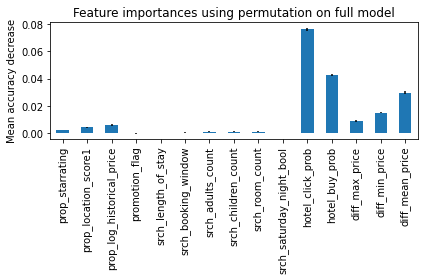

In [175]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [176]:
print(y_test)

[1 1 1 ... 0 1 1]


In [177]:
result = pd.DataFrame(y_test, columns=['actual'])
predicted= pd.DataFrame(y_pred, columns=['predicted'])

df = pd.DataFrame(X_test)



In [178]:
df['result'] = result
df['perdicted'] = predicted

In [179]:
df.to_csv('results.csv') 

In [180]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,result,perdicted
0,5.0,4.33,5.81,1.0,9.0,3.0,1.0,0.0,1.0,0.0,0.042683,0.027439,0.207238,-0.673550,-0.331606,1,0
1,3.0,2.20,4.76,0.0,1.0,27.0,2.0,1.0,1.0,1.0,0.094340,0.075472,1.202128,-0.521277,0.097407,1,1
2,4.0,0.69,4.81,0.0,2.0,16.0,2.0,1.0,1.0,1.0,0.086957,0.043478,1.014423,-0.275380,0.085156,1,1
3,3.0,3.14,5.28,0.0,1.0,28.0,4.0,0.0,2.0,1.0,0.061224,0.061224,0.314465,-0.446541,-0.129380,1,1
4,3.0,2.30,4.78,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.098361,0.081967,0.228571,-0.571429,-0.199711,0,1


# 